# Load Data

In [4]:
%load_ext autoreload
%autoreload 2
from load import load_3D
from liftpose.vision_3d import XY_coord_dict, Z_coord_dict
import yaml
import logging
from imp import reload
import torch
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob

reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# decleare data parameters
par_train = {'data_dir'       : "/data/LiftPose3D/fly_prism/data_oriented/training_data", # change the path 
             'out_dir'        : './out',
             "train_subjects" : ["001", "002", "003"],
             'test_subjects'  : ["004"],
             'actions'        : ['PR']}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# load data
train, train_keypts, _ = load_3D(par["data_dir"], subjects=par['train_subjects'], actions=par['actions'])
test,  test_keypts, _ = load_3D( par["data_dir"], subjects=par['test_subjects'],  actions=par['actions'])
#project data to ventral view
train_2d, train_3d = XY_coord_dict(train), Z_coord_dict(train)
test_2d, test_3d  = XY_coord_dict(test), Z_coord_dict(test)
train_keypts = Z_coord_dict(train_keypts)
test_keypts = Z_coord_dict(test_keypts)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train LiftPose3D Network on DeepFly3D Data

In [2]:
from liftpose.main import train as lp3d_train
lp3d_train(train_2d=train_2d, test_2d=test_2d,
           train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts, test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'])

[main.py:199]:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/fly_prism/out/stat_2d.pth.tar.
[main.py:229]:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/fly_prism/out/stat_3d.pth.tar.
[main.py:250]:INFO:Starting training model.
[main.py:260]:DEBUG:
==================Options=================
[main.py:261]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/fly_prism/out',
    'dropout': 0.5,
    'epochs': 30,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/fly_prism/out',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/fly_prism/out',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:262]:DEBUG:======================================

Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  1.37800|: 100%|██████████| 161/161 [00:02<00:00, 61.94it/s]
Epoch 001 | LR  0.00100 | Loss Test  0.17823 | Loss Train  0.43822|: 100%|██████████| 161/161 [00:02<00:00, 65.20it/s]
Epoch 002 | LR  0.00100 | Loss Test  0.07058 | Loss Train  0.15849|: 100%|██████████| 161/161 [00:02<00:00, 63.79it/s]
Epoch 003 | LR  0.00100 | Loss Test  0.05524 | Loss Train  0.07220|: 100%|██████████| 161/161 [00:02<00:00, 60.24it/s]
Epoch 004 | LR  0.00100 | Loss Test  0.04441 | Loss Train  0.04849|:   4%|▍         | 7/161 [00:00<00:09, 16.68it/s]


KeyboardInterrupt: 

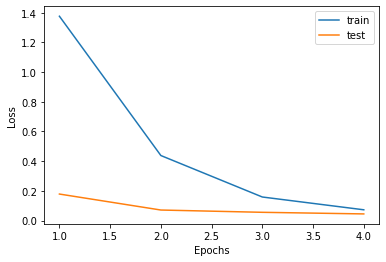

In [7]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [8]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:284]:INFO:starting testing in path: ./out
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:55]:INFO:total params: 4.28M
[lift.py:61]:INFO:loading ckpt from './out/ckpt_best.pth.tar'
[lift.py:69]:INFO:ckpt loaded (epoch: 4 | err: 1.15083766905785)
[lift.py:105]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/fly_prism/out/test_results.pth.tar


# Visualize Predictions

In [63]:
from liftpose.postprocess import load_test_results
data = torch.load(par['out_dir'] + "/test_results.pth.tar")
stat_2d, stat_3d = (
    torch.load(par['out_dir'] + "/stat_2d.pth.tar"),
    torch.load(par['out_dir'] + "/stat_3d.pth.tar"),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d, prism=True)

In [64]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
%matplotlib widget
from liftpose.preprocess import add_roots
#%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=45, azim=0)

t = 12
plot_pose_3d(ax, tar=test_3d_gt[t],
            pred=test_3d_pred[t],
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            good_keypts=good_keypts[t],
            show_gt_always=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …